### Условие задачи (на основе CUPED)

В онлайн-эксперименте мы хотим **снизить дисперсию метрики** (стоимость покупок на пользователя) с помощью **метода CUPED** — использования информации до эксперимента (препилотного периода) для корректировки оценки метрики во время эксперимента (пилота).

Нужно реализовать:

1. `calculate_metric(...)` — функцию, которая по списку пользователей считает **метрику (сумму значений)** на заданном временном промежутке.
2. `calculate_metric_cuped(...)` — функцию, которая:

   * считает метрику до эксперимента (`_prepilot`),
   * считает метрику во время эксперимента (`metric_name`),
   * считает **CUPED-преобразование** метрики:

     $$
     \text{CUPED} = Y - \theta (X - \bar{X})
     $$

     где:

     * $Y$ — метрика во время пилота,
     * $X$ — метрика до пилота (ковариата),
     * $\bar{X}$ — среднее по X,
     * $\theta = \frac{cov(Y, X)}{var(X)}$



In [1]:
import numpy as np
import pandas as pd

In [2]:
# Функция для расчёта метрики за период
def calculate_metric(df, value_name, user_id_name, list_user_id, date_name, period, metric_name):
    df_filtered = df[
        (df[user_id_name].isin(list_user_id)) &
        (df[date_name] >= period['begin']) &
        (df[date_name] < period['end'])
    ]

    result = df_filtered.groupby(user_id_name)[value_name].sum().reset_index()
    result.rename(columns={value_name: metric_name}, inplace=True)

    # Обеспечим наличие всех пользователей
    result = pd.merge(
        pd.DataFrame({user_id_name: list_user_id}),
        result,
        on=user_id_name,
        how='left'
    ).fillna({metric_name: 0})

    return result

In [3]:
# Функция для расчёта CUPED-метрики
def calculate_metric_cuped(df, value_name, user_id_name, list_user_id, date_name, periods, metric_name):
    # Считаем метрику в препилоте
    df_prepilot = calculate_metric(df, value_name, user_id_name, list_user_id, date_name, periods['prepilot'], f"{metric_name}_prepilot")

    # Считаем метрику в пилоте
    df_pilot = calculate_metric(df, value_name, user_id_name, list_user_id, date_name, periods['pilot'], metric_name)

    # Объединяем
    merged = df_pilot.merge(df_prepilot, on=user_id_name)

    # Считаем theta
    cov = np.cov(merged[metric_name], merged[f"{metric_name}_prepilot"])[0][1]
    var = np.var(merged[f"{metric_name}_prepilot"])
    theta = cov / var if var != 0 else 0

    # CUPED
    x_mean = merged[f"{metric_name}_prepilot"].mean()
    merged[f"{metric_name}_cuped"] = merged[metric_name] - theta * (merged[f"{metric_name}_prepilot"] - x_mean)

    return merged[[user_id_name, metric_name, f"{metric_name}_prepilot", f"{metric_name}_cuped"]]

In [4]:
# Датафрейм с транзакциями
df = pd.DataFrame({
    'user_id': np.random.randint(1, 101, size=500),
    'date': pd.to_datetime(np.random.choice(pd.date_range("2020-01-01", "2020-01-15"), size=500)),
    'revenue': np.random.exponential(10, 500)
})

df.sample(10)

,user_id,date,revenue
476,60,2020-01-05,15.902675
222,90,2020-01-07,8.549998
28,77,2020-01-05,20.188637
87,26,2020-01-10,7.342558
459,39,2020-01-04,5.928748
370,68,2020-01-03,28.297326
88,40,2020-01-12,5.100370
354,89,2020-01-14,1.399151
262,92,2020-01-09,34.622412
122,46,2020-01-09,4.769379


In [5]:
# Задаём периоды
periods = {
    'prepilot': {'begin': '2020-01-01', 'end': '2020-01-08'},
    'pilot': {'begin': '2020-01-08', 'end': '2020-01-15'}
}

# Запускаем расчёт
result = calculate_metric_cuped(df, value_name='revenue', user_id_name='user_id',
                                list_user_id=df['user_id'].unique(), date_name='date',
                                periods=periods, metric_name='revenue')

print(result.head())

   user_id    revenue  revenue_prepilot  revenue_cuped
0        1  16.770533         31.561485      17.006421
1       90  41.339675         12.318446      40.821246
2       82  27.590164         29.836039      27.758416
3        3   0.000000          3.337122      -0.870493
4       51  15.549324          6.193393      14.790796



### Что означают эти значения:

* `revenue`: сумма покупок пользователя в **период пилота** (`pilot`).
* `revenue_prepilot`: сумма покупок **до пилота** (`prepilot`).
* `revenue_cuped`: скорректированная метрика, в которой учтено поведение пользователя **до эксперимента**. Это основная CUPED-метрика.
---

### объяснения:

* **user\_id 1**: до пилота тратил **много** (31.56), а в пилоте — **меньше** (16.77). CUPED компенсирует это, и даёт чуть **выше** (17.01), т.к. ожидаемая активность по прошлым данным выше.

* **user\_id 90**: в пилоте очень активен (41.34), но до этого тратил **мало**. CUPED говорит — не стоит завышать оценку, возможно это случайность. Итоговая оценка **понижается** до 40.82.

* **user\_id 3**: вообще ничего не купил в пилоте (0), но до пилота были траты (3.34). CUPED скорректировал метрику **вниз**, получилось даже **отрицательное значение** (что возможно математически, но нужно интерпретировать как "сильно хуже, чем ожидалось").

---

* **снизили разброс метрики**,
* сделали A/B тест **чувствительнее**,
* учитываем поведение до теста (пользовательский "бэкграунд").


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

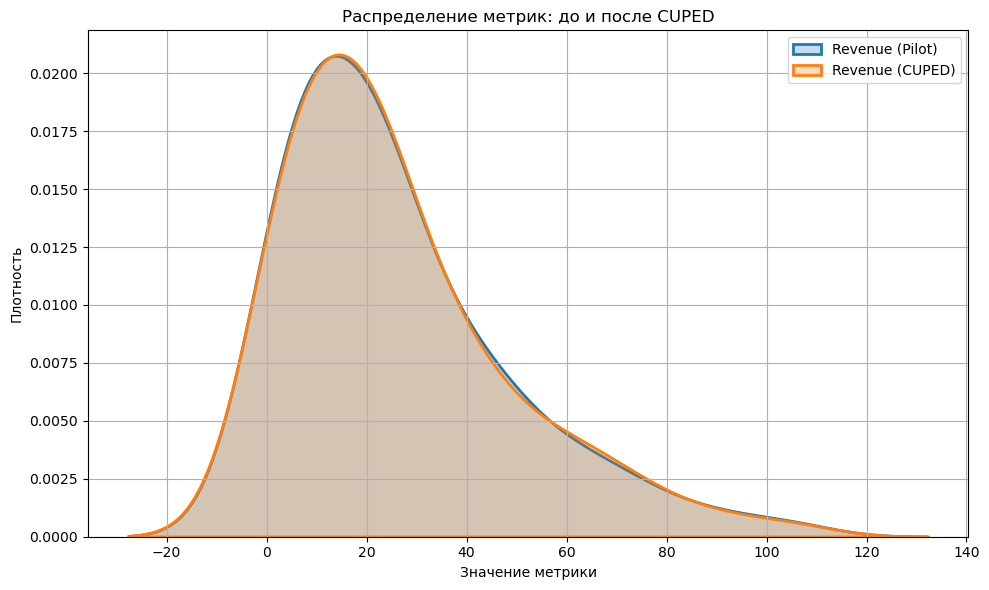

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(result['revenue'], label='Revenue (Pilot)', fill=True, linewidth=2)
sns.kdeplot(result['revenue_cuped'], label='Revenue (CUPED)', fill=True, linewidth=2)
plt.title('Распределение метрик: до и после CUPED')
plt.xlabel('Значение метрики')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()